In [1]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, load_img, img_to_array





# 1. FOLDER PATHS & CSV PATH



In [2]:
# using google drive
from google.colab import drive
drive.mount('/content/drive')

# Folder path
BASE_DIR = "/content/drive/MyDrive/Image Super Resolution - Unsplash"

CSV_PATH = os.path.join(BASE_DIR, "image_data.csv")

# CSV must have columns: 'low_res', 'high_res'
data = pd.read_csv(CSV_PATH)

Mounted at /content/drive


In [15]:
data.head()

,low_res,high_res
0,/content/drive/MyDrive/Image Super Resolution ...,/content/drive/MyDrive/Image Super Resolution ...
1,/content/drive/MyDrive/Image Super Resolution ...,/content/drive/MyDrive/Image Super Resolution ...
2,/content/drive/MyDrive/Image Super Resolution ...,/content/drive/MyDrive/Image Super Resolution ...
3,/content/drive/MyDrive/Image Super Resolution ...,/content/drive/MyDrive/Image Super Resolution ...
4,/content/drive/MyDrive/Image Super Resolution ...,/content/drive/MyDrive/Image Super Resolution ...


In [3]:
# Defining the subfolders for low-res and high-res images
lowres_folder = os.path.join(BASE_DIR, 'low res')
hires_folder = os.path.join(BASE_DIR, 'high res')

# Prepend the specific subfolder paths to the filenames from the CSV
data["low_res"]  = data["low_res"].apply(lambda p: os.path.join(lowres_folder, p))
data["high_res"] = data["high_res"].apply(lambda p: os.path.join(hires_folder, p))3

print("Total samples in CSV:", len(data))
print(data.head())


Total samples in CSV: 3762
                                             low_res  \
0  /content/drive/MyDrive/Image Super Resolution ...   
1  /content/drive/MyDrive/Image Super Resolution ...   
2  /content/drive/MyDrive/Image Super Resolution ...   
3  /content/drive/MyDrive/Image Super Resolution ...   
4  /content/drive/MyDrive/Image Super Resolution ...   

                                            high_res  
0  /content/drive/MyDrive/Image Super Resolution ...  
1  /content/drive/MyDrive/Image Super Resolution ...  
2  /content/drive/MyDrive/Image Super Resolution ...  
3  /content/drive/MyDrive/Image Super Resolution ...  
4  /content/drive/MyDrive/Image Super Resolution ...  



# 2. TRAIN / VAL SPLIT



In [4]:

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    data,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

print("Train samples:", len(train_df), " | Val samples:", len(val_df))


Train samples: 3197  | Val samples: 565



# 3. KERAS SEQUENCE FOR (low_res, high_res) PAIRS


In [6]:

img_height, img_width = 256, 384
batch_size = 8

class PairedImageSequence(Sequence):
    """
    Keras Sequence that loads low_res and high_res image pairs from a DataFrame.
    This solves the 'Unknown' steps_per_epoch issue.
    """
    def __init__(self, df, batch_size, img_size):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_height, self.img_width = img_size

    def __len__(self):
        # Number of batches per epoch
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        # Getting indices for this batch
        batch_df = self.df.iloc[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_size_actual = len(batch_df)
        X = np.zeros((batch_size_actual, self.img_height, self.img_width, 3), dtype="float32")
        Y = np.zeros((batch_size_actual, self.img_height, self.img_width, 3), dtype="float32")

        for i, (_, row) in enumerate(batch_df.iterrows()):
            low_path  = row["low_res"]
            high_path = row["high_res"]

            # Loading low-res image
            low_img = load_img(low_path, target_size=(self.img_height, self.img_width))
            low_arr = img_to_array(low_img) / 255.0   # scale to [0,1]

            # Loading high-res image
            high_img = load_img(high_path, target_size=(self.img_height, self.img_width))
            high_arr = img_to_array(high_img) / 255.0

            X[i] = low_arr
            Y[i] = high_arr

        return X, Y

    def on_epoch_end(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)

# Creating train & validation sequences
train_seq = PairedImageSequence(train_df, batch_size, (img_height, img_width))
val_seq   = PairedImageSequence(val_df,   batch_size, (img_height, img_width))

print(f"Batches per epoch (train): {len(train_seq)}")
print(f"Batches per epoch (val):   {len(val_seq)}")


Batches per epoch (train): 400
Batches per epoch (val):   71


# 4. SANITY CHECK ON ONE BATCH

In [7]:

low_batch, high_batch = train_seq[0]
print("low_batch shape: ", low_batch.shape)
print("high_batch shape:", high_batch.shape)

mse_between_input_and_target = np.mean((low_batch - high_batch) ** 2)
print("MSE between low_res and high_res in first batch:", mse_between_input_and_target)


low_batch shape:  (8, 256, 384, 3)
high_batch shape: (8, 256, 384, 3)
MSE between low_res and high_res in first batch: 0.008097939


# 5. SIMPLE CONV AUTOENCODER (small & fast)


In [8]:

input_img = layers.Input(shape=(img_height, img_width, 3))

# ----- Encoder -----
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)     # -> H/2 x W/2 x 16

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)     # -> H/4 x W/4 x 32

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # -> H/8 x W/8 x 64

# ----- Decoder -----
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)                     # -> H/4 x W/4 x 64

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                     # -> H/2 x W/2 x 32

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)                     # -> H x W x 16

decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # -> H x W x 3

autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 384, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 192, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 192, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 96, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 192, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 384, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 384, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,035 (328.26 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

#6. CALLBACKS

In [9]:

model_path = os.path.join(BASE_DIR, "simple_autoencoder_seq.h5")

checkpoint = ModelCheckpoint(
    model_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, earlystop, reduce_lr]


# 7. TRAINING

In [ ]:

#EPOCHS = 10

#history = autoencoder.fit(
 #   train_seq,
  #  validation_data=val_seq,
   # epochs=EPOCHS,
    #callbacks=callbacks,
    #verbose=1
#)
steps_per_epoch = 50
validation_steps = 10

history = autoencoder.fit(
    train_seq,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_seq,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0698
Epoch 1: val_loss improved from inf to 0.01656, saving model to /content/drive/MyDrive/Image Super Resolution - Unsplash/simple_autoencoder_seq.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 446s 9s/step - loss: 0.0694 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0186
Epoch 2: val_loss improved from 0.01656 to 0.01358, saving model to /content/drive/MyDrive/Image Super Resolution - Unsplash/simple_autoencoder_seq.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 297s 6s/step - loss: 0.0186 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0123
Epoch 3: val_loss improved from 0.01358 to 0.00850, saving model to /content/drive/MyDrive/Image Super Resolution - Unsplash/simple_autoencoder_seq.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - loss: 0.0123 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0095
Epoch 4: val_loss did not improve from 0.00850
50/50 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - loss: 0.0095 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0098
Epoch 5: val_loss did not improve from 0.00850
50/50 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - loss: 0.0098 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0095
Epoch 6: val_loss improved from 0.00850 to 0.00796, saving model to /content/drive/MyDrive/Image Super Resolution - Unsplash/simple_autoencoder_seq.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - loss: 0.0095 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0092
Epoch 7: val_loss did not improve from 0.00796
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 0.0092 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0080
Epoch 8: val_loss improved from 0.00796 to 0.00766, saving model to /content/drive/MyDrive/Image Super Resolution - Unsplash/simple_autoencoder_seq.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 0.0080 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0069
Epoch 9: val_loss did not improve from 0.00766
50/50 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 0.0069 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 10/10
42/50 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0073

# 8. PLOT TRAINING & VALIDATION LOSS

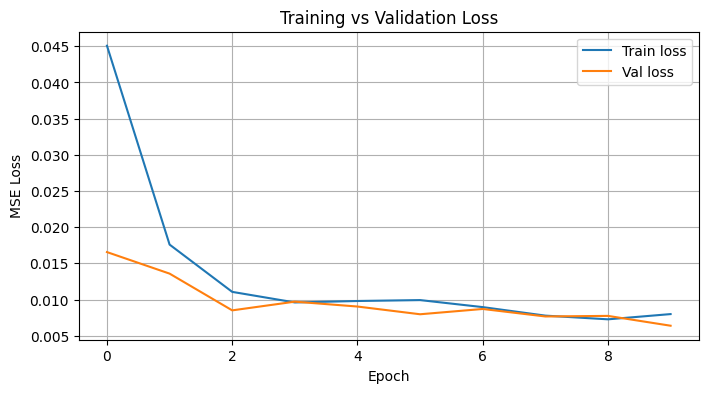

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 9. VISUALISE PREDICTIONS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


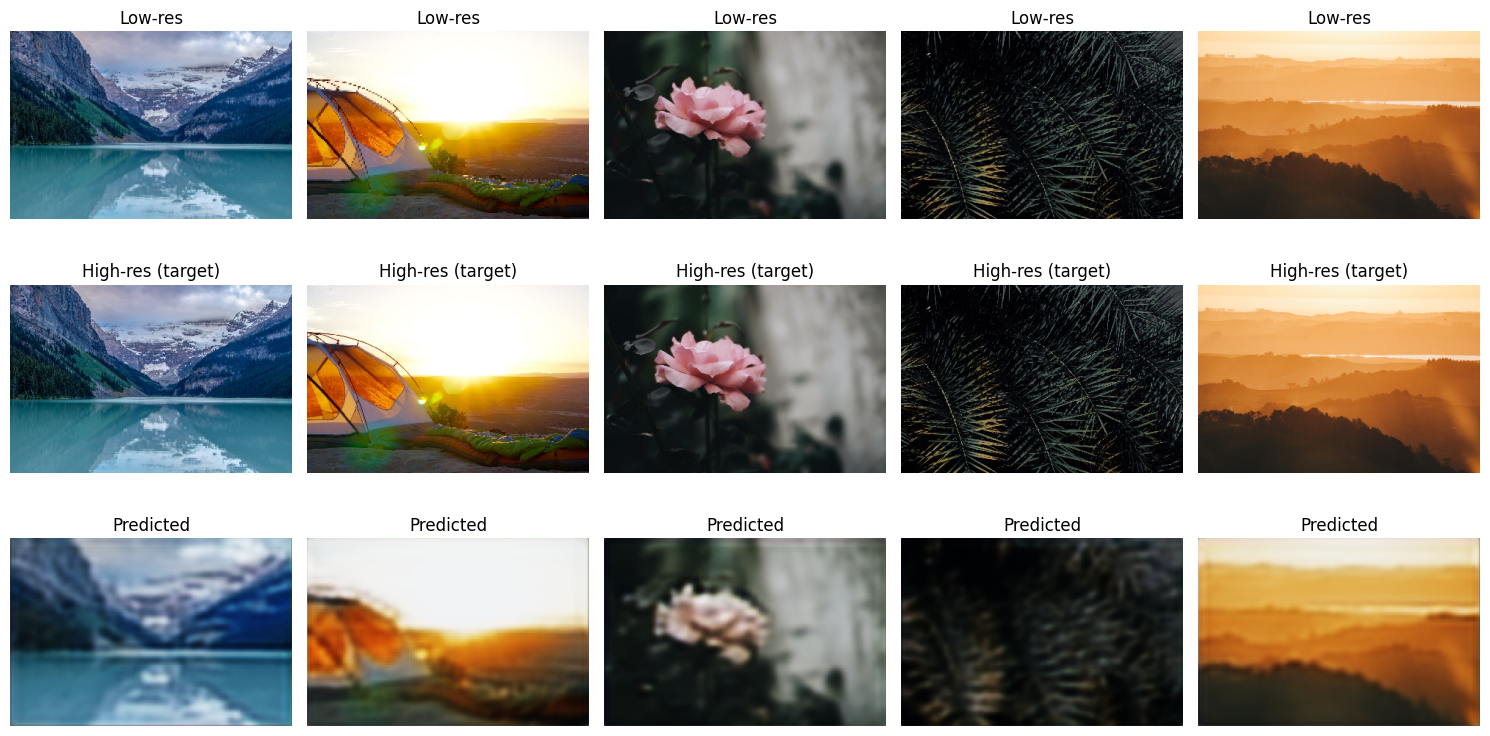

In [13]:

# we are using best weights
autoencoder.load_weights(model_path)

# Taking a batch from validation
low_batch, high_batch = val_seq[0]  # first batch
pred_batch = autoencoder.predict(low_batch)

n = min(5, len(low_batch))  # number of samples to display
plt.figure(figsize=(15, 8))

for i in range(n):
    # Low-res
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(low_batch[i])
    ax.set_title("Low-res")
    plt.axis("off")

    # Ground truth high-res
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(high_batch[i])
    ax.set_title("High-res (target)")
    plt.axis("off")

    # Predicted high-res
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(pred_batch[i])
    ax.set_title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()